# BME 599 Visualization Project
##### Andrea Jacobson, Christopher Louly </br> Due Tue 12/09/2025


This file contains all the code to perform Bloch Simulations and create plots for the Fall 2025 BME599 Visualization Project. All of the actual Bloch Simulation code can be found in `./UM_Blochsim/`, which was written in C for efficiency by the the authors of this submission before this project was assigned. This is an adaptation of the code found in https://github.com/chlouly/UM_Blochsim so that it may be used by anyone wishing to run this code without cloning and installing UM_Blochsim.

**NOTE:** For the animations to render and save, you must have `ffmpeg` installed on your machine, sorry for the inconvenience. Once ffmpeg is installed, you must update the `FFMPEG_PATH` variable in the cell below to reflect the path to `ffmpeg` on your machine. In bash (or most other shells), you can run `which ffmpeg` to retrieve the path.


In [1]:
# --- IMPORTS --- #

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FFMPEG_PATH = "/usr/bin/ffmpeg"
# FFMPEG_PATH = "/opt/homebrew/bin/ffmpeg"
mpl.rcParams['animation.ffmpeg_path'] = FFMPEG_PATH
mpl.rcParams['animation.html'] = "jshtml"

from pulsegen import *
from plotting import *
from UM_Blochsim import *

### Setting Up The Simulation

In this section, we will essentially construct an array `B_eff` which holds the effective field strength as a function of time and isochromat position so that we may run Bloch simulations over each isochromat.

In [2]:
# --- DEFINE CONSTANTS --- #

# Sequence Parameters
TE = 80             # Echo Time [ms]
ETL = 8             # Echo Train Length
PW = 2              # Width of Excitation and Refocuser Pulses [ms]
G_dur = 30          # Frequency Encoding Gradient Durration [ms]
G_amp = 0.0015      # Frequency Encoding Gradient Amplitude [T/cm]
start_pad = 5       # Dead time at the beginning of sequence [ms]
dt = 0.01           # Simulation Timestep [ms]

# Multi-isochromat Parameters
num_iso = 50        # Number of Isochromats to Simulate
vox_x = 10**-3      # Voxel Size [cm] (in the x direction)
fenc_dim = 0        # Dimension along which we frequency encode

# Plotting
dsamp = 50          # Downsampling factor for plotting
PLOT_PATH = "./plots/"


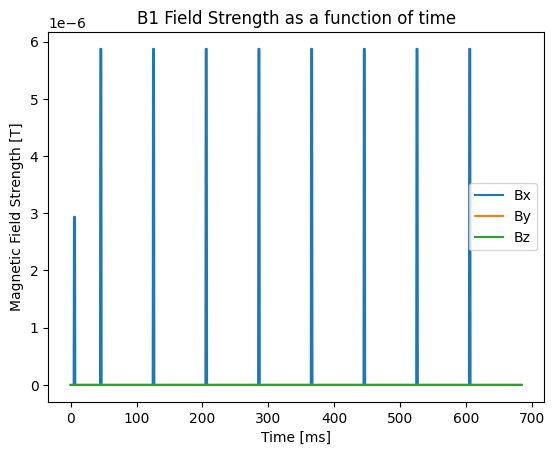

In [3]:
# Create a B1 Array 
B1, T = fse_pulsetrain(PW, ETL, TE, dt, start_pad=start_pad)

# Create a time vector for plotting
ntime = B1.shape[0]
time = np.arange(ntime) * dt

# Plot it as a sanity check
plt.plot(time[::dsamp], B1[::dsamp, 0], label="Bx")
plt.plot(time[::dsamp], B1[::dsamp, 1], label="By")
plt.plot(time[::dsamp], B1[::dsamp, 2], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetic Field Strength [T]")
plt.title("B1 Field Strength as a function of time")
plt.legend()
plt.show()

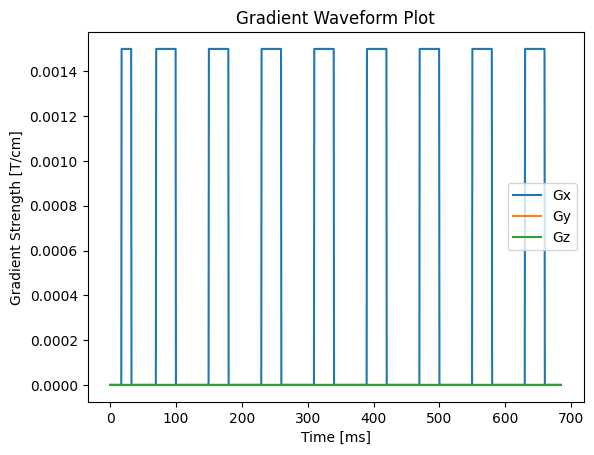

In [4]:
# Create a Gradient Waveform Array
#   We can choose the frequency encoding gradient in any direction, for the purposes 
#   of thissimulation, it doesn't matter, so we choose the x direction.
G, T_G = fse_freq_enc_grad(G_amp, G_dur, ETL, TE, dt, start_pad=start_pad, dim=fenc_dim)

# Make sure the gradient waveform durration is the same as B1 waveform durration
assert(T == T_G)

# Plot G as a sanity check
plt.plot(time[::dsamp], G[::dsamp, 0], label="Gx")
plt.plot(time[::dsamp], G[::dsamp, 1], label="Gy")
plt.plot(time[::dsamp], G[::dsamp, 2], label="Gz")
plt.xlabel("Time [ms]")
plt.ylabel("Gradient Strength [T/cm]")
plt.title("Gradient Waveform Plot")
plt.legend()
plt.show()


In [5]:
# Create Isochrmat positions
iso_pos = np.zeros((3, num_iso))
iso_pos[fenc_dim, :] = np.linspace(-vox_x / 2, vox_x / 2, num_iso)

# Create a 3-array of Effective B fields with the following dimensions:
#       B_eff.shape = (N, D, I)
# Where:
#       N is the number of timepoints to be simulated (same as the variable ntime)
#       D is the number of spatial dimensions (always 3)
#       I is the number of isochromats to be simulated (same as the variable num_iso)
# We use the formula:
#       B_eff = B1 + (G * r)
B_eff = np.zeros((ntime, 3, num_iso))
# B_eff = np.tile(B1.reshape(B1.shape + (1,)), (1, 1, num_iso))           # Repeat B1 for each isochromat
# B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)   # We add the Field of the gradient at each isochromat location
B_eff += B1[:, :, None]
B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)


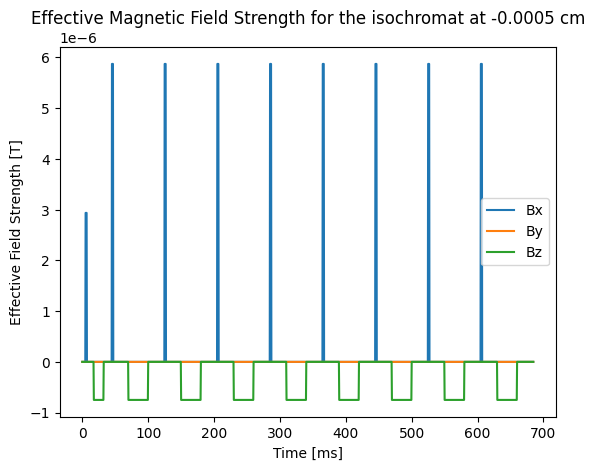

In [6]:
# We can plot the B_eff signal for a particular isochromat as a sanity check. As we change plot_iso_ind, we should see the signal change
plot_iso_ind = 0

plt.plot(time[::dsamp], B_eff[::dsamp, 0, plot_iso_ind], label="Bx")
plt.plot(time[::dsamp], B_eff[::dsamp, 1, plot_iso_ind], label="By")
plt.plot(time[::dsamp], B_eff[::dsamp, 2, plot_iso_ind], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Effective Field Strength [T]")
plt.title(f"Effective Magnetic Field Strength for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm")
plt.legend()
plt.show()

### 2.1 Brain Imaging

In [7]:
# Let's compare Lesioned White Matter Vs Healthy White Matter

# Parameter Values
# Healthy
T1_hlth = 850
T2_hlth = 60
# Lesioned
T1_lsnd = 1400
T2_lsnd = 80

# Initialize outputs for both cases
M_hlth = np.zeros((ntime, 3, num_iso))
M_lsnd = np.zeros((ntime, 3, num_iso))

# Simulate
for i in range(num_iso):
    print(B_eff[:, :, i].shape)
    M_hlth[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_hlth, T2_hlth, dt)
    M_lsnd[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_lsnd, T2_lsnd, dt)

(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.000000 ]
(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.000000 ]
(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.000000 ]
(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.000000 ]
(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.000000 ]
(68500, 3)
h:0.020000
T1: 850.000000   T2: 60.000000

[ 0.000000   0.000000   0.000000 ]
h:0.020000
T1: 1400.000000   T2: 80.000000

[ 0.000000   0.000000   0.0

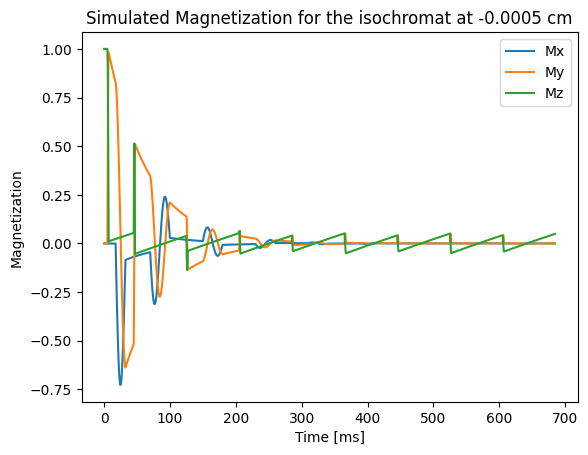

In [8]:
# For a sanity check, let's plot the simulated M(t) for one isochromat
plot_iso_ind = 0

plt.plot(time[::dsamp], M_hlth[::dsamp, 0, plot_iso_ind], label="Mx")
plt.plot(time[::dsamp], M_hlth[::dsamp, 1, plot_iso_ind], label="My")
plt.plot(time[::dsamp], M_hlth[::dsamp, 2, plot_iso_ind], label="Mz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetization")
plt.title(f"Simulated Magnetization for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm")
plt.legend()
plt.show()

(68500, 3, 50)
3
HERE


Animation saved to: ./plots/2_1_Healthy_WM_individual_isochromats.mp4
(68500, 3, 50)
3
HERE
Animation saved to: ./plots/2_1_Lesioned_WM_individual_isochromats.mp4


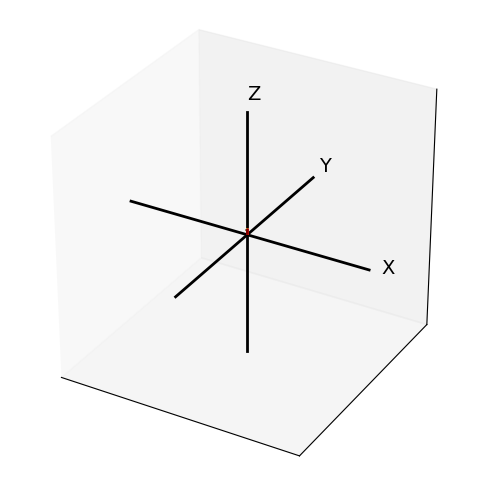

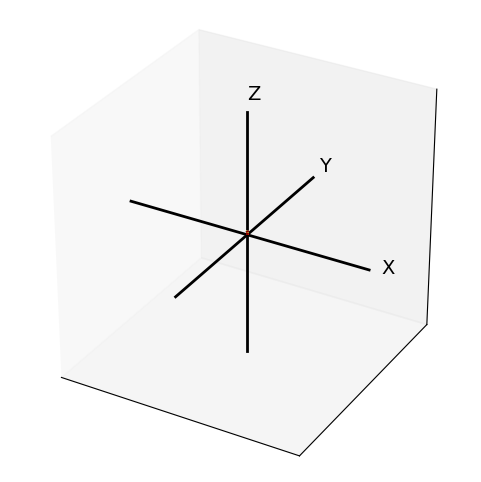

In [9]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
plot_iso_3D(M_hlth, PLOT_PATH + "2_1_Healthy_WM_individual_isochromats.mp4", dsamp=dsamp)
plot_iso_3D(M_lsnd, PLOT_PATH + "2_1_Lesioned_WM_individual_isochromats.mp4", dsamp=dsamp)

In [10]:
# We can now construct the total magnetization by taking the superposition of all isochromats in each voxel
M_hlth_tot = np.mean(M_hlth, axis=2)
M_lsnd_tot = np.mean(M_lsnd, axis=2)

# We also can find the received signal, which will be the l2 norm of the transverse magnetization at each timepoint
S_hlth = np.linalg.norm(M_hlth_tot[:, 0:2], axis=1)
S_lsnd = np.linalg.norm(M_lsnd_tot[:, 0:2], axis=1)

# Samity Check
print(M_hlth_tot.shape)
print(S_hlth.shape)

(68500, 3)
(68500,)


In [ ]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
plot_iso_3D(M_hlth_tot, PLOT_PATH + "2_1_Healthy_WM_M_total.mp4", dsamp=dsamp)
plot_iso_3D(M_lsnd_tot, PLOT_PATH + "2_1_Lesioned_WM_M_total.mp4", dsamp=dsamp)

(68500, 3)
2


In [ ]:
# Now we can make a plot showing the difference in signal intensity for the two cases to display their difference
plt.plot(time[::dsamp], S_hlth[::dsamp], label="Healthy White Matter")
plt.plot(time[::dsamp], S_lsnd[::dsamp], label="Lesioned White Matter")
plt.xlabel("Time [ms]")
plt.ylabel("Signal Intensity")
plt.title("Plot of the received signal for two neural tissue species")
plt.legend()
plt.show()

### 2.2 Spinal Cord Imaging

### Heart Imaging

Notes: Talk about offresonance in this one around the lungs